Notebook for testing gridded images(16x16) with segmentation included in the preprocessing pipeline. Images are gridded according to a specfied size and the resized to 16x16 before being normalized and segmented. Preprocessed images are passed throught the classifier and their results labeled on the original image.


In [ ]:
!git clone https://github.com/Virtana/Agri_Classification.git

Cloning into 'Agri_Classification'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 24 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from PIL import Image
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt



class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.fc1 = nn.Linear(144, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
PATH = '/content/Agri_Classification/Models/base_color_transform_nocorn_16p_.pth'

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
test_transform = transforms.Compose([transforms.Resize((16)),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 

In [ ]:
import numpy as np
#code to display a torch image
def imshow(img, correct = True):
    if(correct):
      img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.rcParams["figure.figsize"] = (20,20)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
image = transforms.ToTensor()(Image.open('/content/Agri_Classification/Data/20220717_145704.jpg'))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Seg(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 3, 3, padding = 1)
        # #self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 2)
        # self.conv3 = nn.Conv2d(16, 6, 3)
        # self.conv4 = nn.Conv2d(6, 3, 3)
        

    def forward(self, x):
        #print(x.shape)
        # x = self.pool(F.relu(self.conv1(x)))
        # #print(x.shape)
        # x = self.pool(F.relu(self.conv2(x)))
        # #print(x.shape)
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # #print(x.shape)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv1(x)
        # x = self.conv2(x)
        # x = self.conv3(x)
        # x = self.conv4(x)
        return x


seg = Seg()
PATH = '/content/base_color_transform_nocorn_epoch_9.pth'
seg.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
def grid_image(image, transform, size = 1024):
  imgs = []
  for i in range(image.shape[1] // size):
    #print(i)
    for j in range(image.shape[2] // size):
      imgs.append(transform(image[:,i*size:(i+1)*size, j*size:(j+1)*size]))
      #imgs.append(img[i*size:(i+1)*size, j*size:(j+1)*size, :])
  return imgs

In [ ]:
imgs = grid_image(image, test_transform, size = 512)

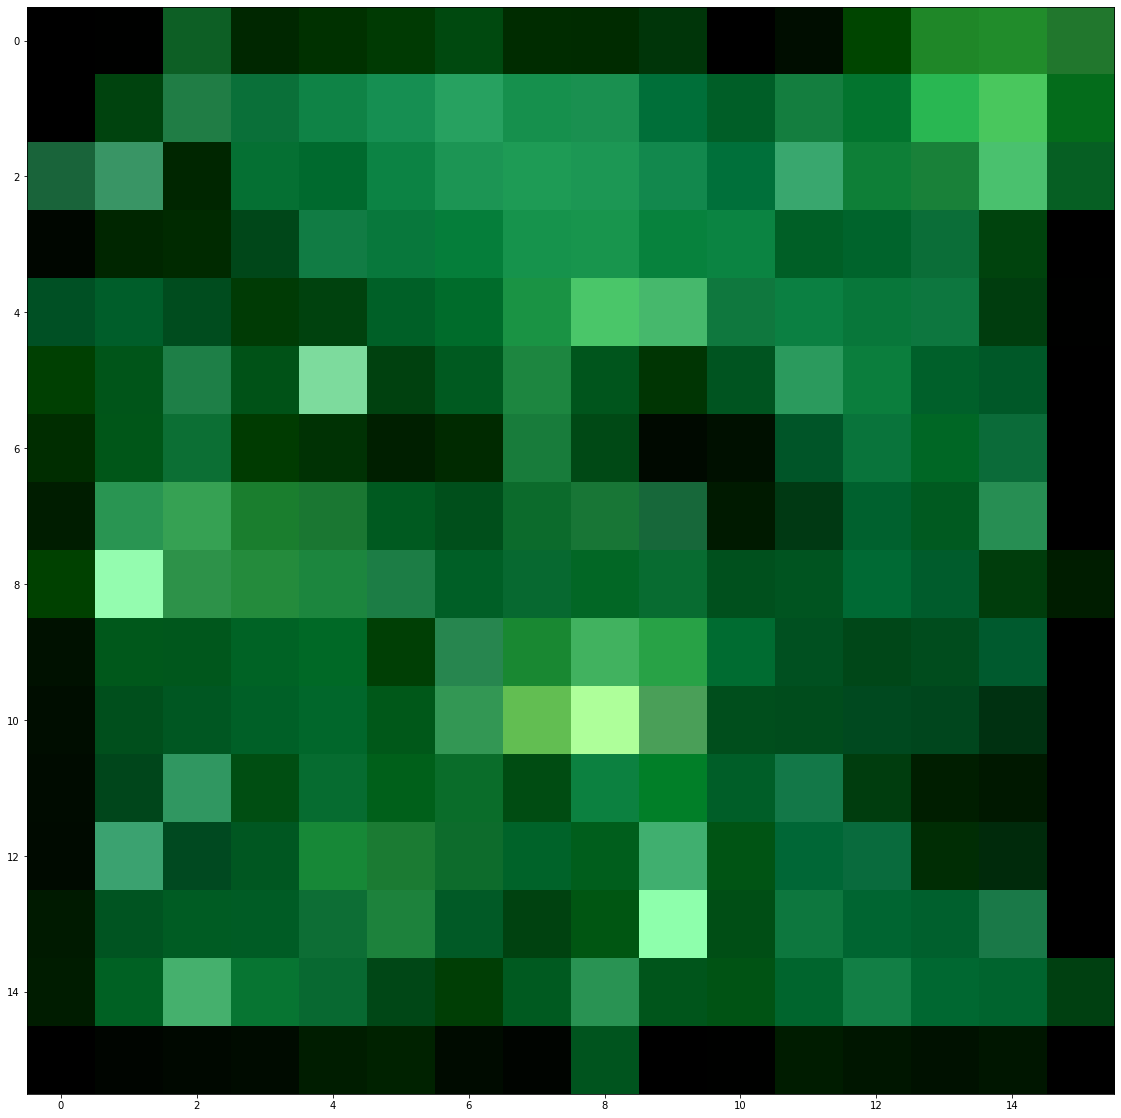

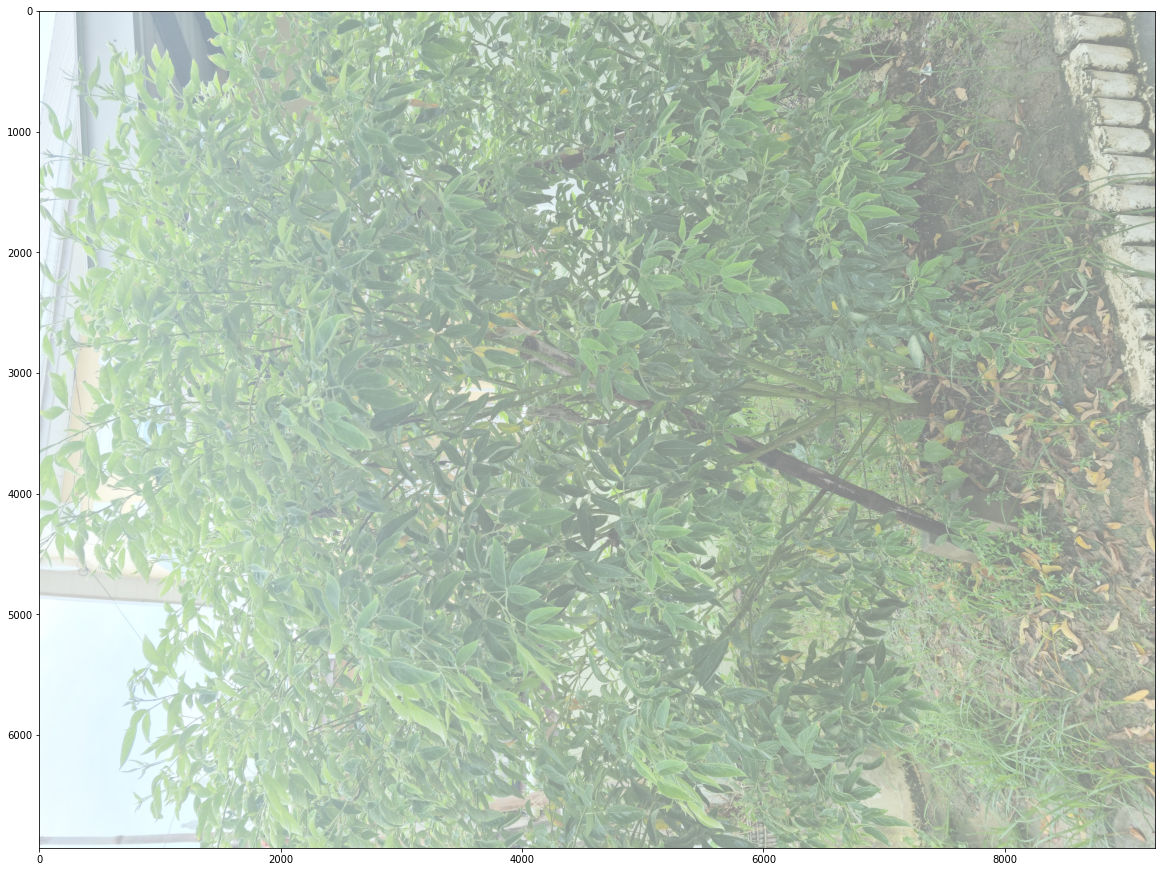

In [ ]:
out = seg(imgs[100])
imshow(out.detach())
imshow(image)

In [ ]:
correct = 0
total = 0
predictions = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for img in imgs:
        inputs = torch.stack([img])
        # labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(predicted)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()
preds = torch.stack(predictions)

In [ ]:
def draw_box(image, tl, size, thickness = 60, color = 1):
  #print(color)
  #print(tl)
  t = thickness
  #image[color,tl[0]:tl[0]+ size,tl[1]:tl[1]+size] = 1
  image[color,tl[0]:tl[0]+ size,tl[1]: tl[1] + t] = 1 #left vertical
  image[color,tl[0]: tl[0] + t,tl[1]:tl[1]+ size] = 1 #top horizontal
  image[color,tl[0]:tl[0]+ size,tl[1] + size: tl[1] + size - t] = 1 #right vertical
  image[color,tl[0] + size: tl[0] + size - t,tl[1]:tl[1]+ size] = 1 #bottom horizontal
  return image

def label_grid(image, size, labels, draw_box):
  x = 0
  for i in range(image.shape[1] // size):
    for j in range(image.shape[2] // size):
      image = draw_box(image, (i*size,j*size), size, color = labels[x])
      x += 1
  return image

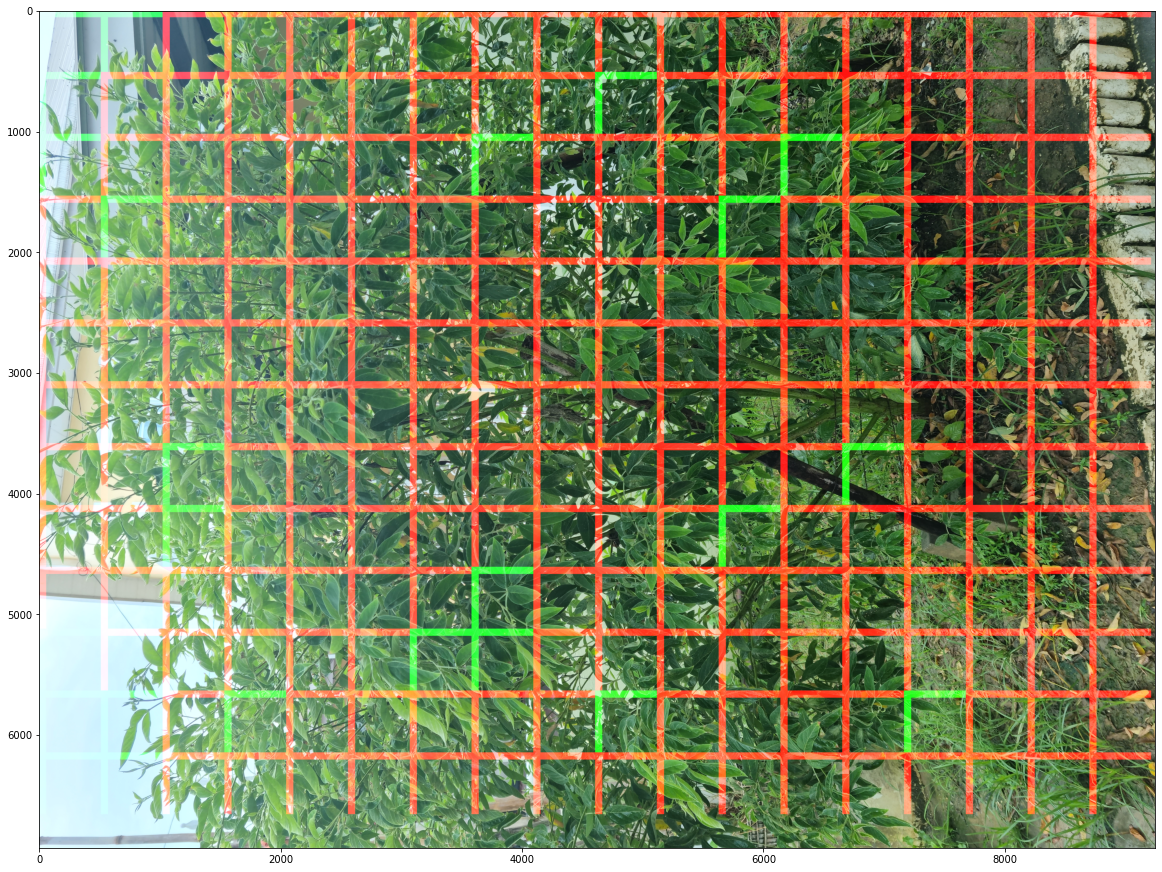

In [ ]:
copy_image = image.clone()
imshow(label_grid(copy_image, 512, preds, draw_box), False)

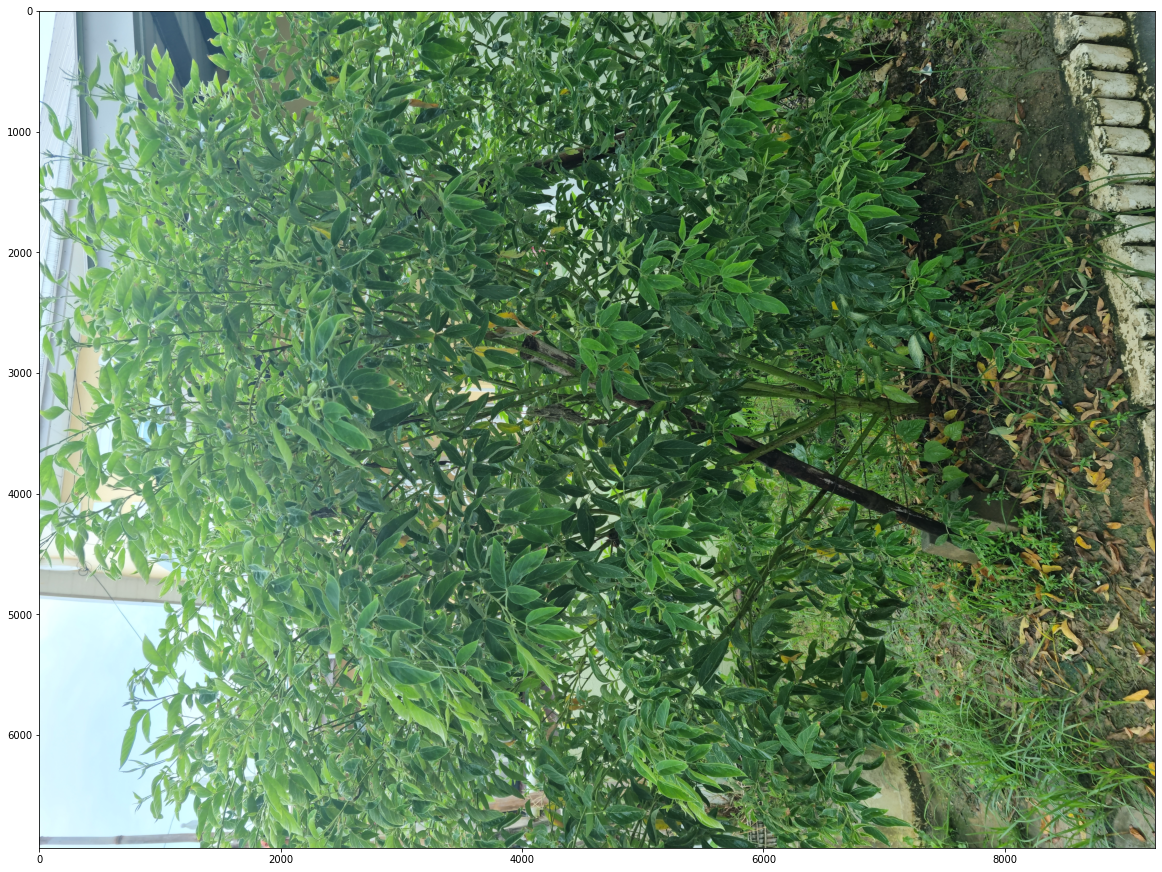

In [ ]:
imshow(image,False)